In [2]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from copy import deepcopy as dcopy,copy
import numba as nb

<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/01/20180102_sudoku.png" width="450">

In [75]:
# Setup the constraints
fixed = np.array([[ 0, 0, 9, 0, 0, 9,49, 0, 0],
                  [ 9, 0,25, 0, 0, 0,36, 0, 0],
                  [49, 0, 0,36,16, 9, 0,81,25],
                  [ 4,49, 0, 1, 0, 0, 9, 0,81],
                  [ 0, 0,81, 0, 0, 0,16, 0, 0],
                  [ 9, 0,64, 0, 0, 4, 0, 4, 6],
                  [36,16, 0,16, 4,25, 0, 0,49],
                  [ 0, 0,49, 0, 0, 0, 9, 0, 4],
                  [ 0, 0,36,49, 0, 0,16, 0, 0]],dtype=int)

In [116]:
class Matrix():
    def __init__(self,fixed,filled = np.zeros((9,9),dtype=int)):
        self.fixed = fixed
        self.filled = filled
        x= np.ones((3,3))
        self.groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])
        self.solution =[]
        self.early_stop = 0
  
    ################################################
    # Two functions. One to check if the remotes force
    # the number and one to check if the cell forces
    #Function to check if a digit can be placed in the given block
    
    @staticmethod
    #@nb.njit
    def possible(row,col,digit,grid,fixed):
    
        if digit in grid[row,:]:
                return False
        if digit in grid[:,col]:
                return False

        square_row = (row//3)*3
        square_col = (col//3)*3
        for i in range(0,3):
            for j in range(0,3):
                if grid[square_row+i,square_col+j] == digit:
                    return False  
        
        #print(row,col,digit)
        test_result = True
        
        if row-1 > -1:
            
            if fixed[row-1,col] !=0:
                test_num = fixed[row-1,col]
                neighbours = [-1,-1,-1,-1]
                if row-2 >-1:
                    neighbours[0] = grid[row-2,col] 
                if row <9:
                    neighbours[1] = digit
                if col-1 >-1:
                    neighbours[2] = grid[row-1,col-1]
                if col+1 <9:
                    neighbours[3] = grid[row-1,col+1]
                #print(neighbours)
                if 0 not in neighbours:
                    test_result = False
                    for i in range(4):
                        for j in range(i+1,4):
                            if neighbours[i]* neighbours[j] == test_num:
                                
                                test_result = True
            
        if row+1 < 9:        
                if fixed[row+1,col] !=0:
                    test_num = fixed[row+1,col]
                    neighbours = [-1,-1,-1,-1]
                    if row >-1:
                        neighbours[0] = digit
                    if row +2 <9:
                        neighbours[1] = grid[row+2,col] 
                    if col-1 >-1:
                        neighbours[2] = grid[row+1,col-1]
                    if col+1 <9:
                        neighbours[3] = grid[row+1,col+1]
        
                    if 0 not in neighbours:
                        test_result = False
                        for i in range(4):
                            for j in range(i+1,4):
                                if neighbours[i]* neighbours[j] == test_num:
                                    test_result = True
            
        if col -1 > -1:        
            if fixed[row,col-1] !=0:
                #print("check",fixed[row,col-1])
                test_num = fixed[row,col-1]
                neighbours = [-1,-1,-1,-1]
                if row-1 >-1:
                    neighbours[0] = grid[row-1,col-1] 
                if row +1 <9:
                    neighbours[1] = grid[row+1,col-1] 
                if col-1 >-1:
                    neighbours[2] = grid[row,col-2]
                if col <9:
                    neighbours[3] = digit
                #print(neighbours)
                if 0 not in neighbours:
                    test_result = False
                    for i in range(4):
                        for j in range(i+1,4):
                            if neighbours[i]* neighbours[j] == test_num:
                                test_result = True
                                
        if col +1 < 9:        
            if fixed[row,col+1] !=0:
                test_num = fixed[row,col+1]
                neighbours = [-1,-1,-1,-1]
                if row-1 >-1:
                    neighbours[0] = grid[row-1,col+1] 
                if row +1 <9:
                    neighbours[1] = grid[row+1,col+1] 
                if col >-1:
                    neighbours[2] = digit
                if col+2 <9:
                    neighbours[3] = grid[row,col+2]
        
                if 0 not in neighbours:
                    test_result = False
                    for i in range(4):
                        for j in range(i+1,4):
                            if neighbours[i]* neighbours[j] == test_num:
                                test_result = True
    
        return test_result

    def backtrack(self):
        if self.early_stop ==0:
            for row,col in itertools.product(range(8,-1,-1),range(8,-1,-1)):
                if self.filled[row,col] == 0:
                    for digit in range(1,10):
                        if self.possible(row,col,digit,self.filled,self.fixed):
                            self.filled[row,col] = digit
                            self.backtrack()
                            self.filled[row,col] = 0  #Backtrack step
                    return
            #print(self.filled)
            self.early_stop = 1      
            self.solution = dcopy(self.filled)
        
   
    ##############################################
    # Two more functions
    # From the solved grid get the score  
    # Loop through and print the grids
    
    def score(self):
        return  np.sum((self.solution[self.fixed!=0]**2))
    
    def sol_print(self):      
        fig,ax = plt.subplots(1,2,figsize=(8,4))
        count = 0
        x = np.array(self.solution.astype('int').astype('str'))
        x[x=="0"] ="-"
        y = (self.fixed > 0) + self.groups*2
        ax[0] = sns.heatmap(y,annot=x,cbar=False,cmap="tab20",fmt="",vmin=0,vmax=19,linewidths=1,annot_kws={"size":16},ax=ax[0])
        ax[0].axis("off")
        x1 = np.array(self.fixed.astype('int').astype('str'))
        x1[x1=="0"] ="-"
        y1 = (self.fixed > 0) 
        
        ax[1] = sns.heatmap(y1,annot=x1,cbar=False,cmap="Greys",fmt="",vmin=0,vmax=5,linewidths=1,annot_kws={"size":16},ax=ax[1])
        ax[1].axis("off")
        plt.tight_layout()
   
                         
    ###############################################
    # Main solver.  
    def solve(self):
        start = time.perf_counter()
        self.backtrack()
        stop = time.perf_counter()
        print("***Solved in {:.4f} seconds***".format(stop - start))
        #print("The sum of the squares of the numbers  is {:,.0f}".format(self.score()))
        #print("Still unsolved",np.sum(self.filled==0))
        print("\nSolved Grid")
        print("~~~~~~~~~~~~")
        self.sol_print()
        

***Solved in 42.8884 seconds***

Solved Grid
~~~~~~~~~~~~


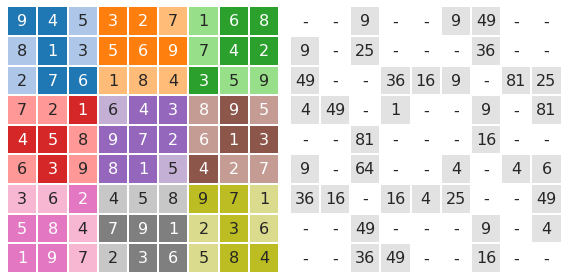

In [117]:
test= np.array([[9,4,5,3,2,7,1,6,8],
                   [8,1,3,5,6,9,7,4,2],
                   [2,7,6,1,8,4,3,5,9],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0]] 
                  ,dtype=int)


test = Matrix(fixed,test)
test.solve()


In [101]:
url='https://www.janestreet.com/puzzles/solutions/january-2018-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]

print(" ".join(x[7:10]))

The completed grid is shown to the left, and the sum of the squares of the numbers written over the grey clue values is 1146 .


<img src="https://www.janestreet.com/puzzles/wp-content/uploads/2018/02/20180201_sudoku_ans.png" width="250" >

In [50]:
correct= np.array([[9,4,5,3,2,7,1,6,8],
                   [8,1,3,5,6,9,7,4,2],
                   [2,7,6,1,8,4,3,5,9],
                   [7,2,1,6,4,3,8,9,5],
                   [4,5,8,9,7,2,6,1,3],
                   [6,3,9,8,1,5,4,2,7],
                   [3,6,2,4,5,8,9,7,1],
                   [5,8,4,7,9,1,2,3,6],
                   [1,9,7,2,3,6,5,8,4]] 
                  ,dtype=int)